Uses coin betting instead of Adam, hence no learning rate to tune.

# Simulation

**Simulation**: $y \sim \text{Bournelli}(x_j)$, $\rho$ is false positive rate, and $\beta$ is classifier threshold,  
\begin{align}
\rho(x_j, y, \beta) &= 1_{\beta \leq x_j} (1 - y).
\end{align}
If $x_j \sim U([0, 1])$ then 
\begin{align}
\theta &= \mathbb{E}_{\substack{x \sim U([0, 1]) \\ y \sim \text{Bournelli}(x_j)}}\left[ 1_{\beta^* \leq x} (1 - y) \right] \\
&= \mathbb{E}_{x \sim U([0, 1])} \left[ 1_{\beta^* \leq x} (1 - x) \right] \\
&= \frac{1}{2} \left(1 - \beta^*\right)^2, \\
\implies \beta^* &= 1 - \sqrt{2 \theta}.
\end{align}

# Shootout

Choices are
\begin{align}
\log\left(1 + \lambda \left( \theta - \frac{l}{q(x)} \rho(x, y, \beta) \right) \right) && \left(\text{partial}\right) \\
\log\left(1 + \lambda \left( \left(\theta - 1\right) - \frac{l}{q(x)} \left(\rho(x, y, \beta) - 1 \right)\right) \right) && \left(\text{shifted}\right) \\
\log\left(1 + \lambda \frac{l}{q(x)}  \left( \theta - \rho(x, y, \beta) \right) \right) && \left(\text{full}\right) \\
\log\left(1 + \lambda \left( \theta - \rho(x, y, \beta) \right) \right) && \left(\text{sample everything}\right) \\
\end{align}
and finally, "oblivious partial" is partial with a constant sampling policy $q(x)$ independent of $x$.  If partial does not outperform "oblivious partial", that suggests the learning algorithm isn't doing anything useful.  Furthermore the gap between "sample everything" and "oblivious partial" represents the cost imposed by the increased range (smaller maximum bet) and larger variance (smaller optimal bet) of the random variable when sampling.

**Results Inconclusive**: What's better (in terms of label efficiency)?  Mostly it depends upon the random seed, suggesting all approaches are nearly equivalent.  Exception: shifted seems really bad for this particular problem.  **Update**: running a bunch of seeds reveals a slight advantage to active learning over labelling everything, with full and partial being statistically equivalent.

In [1]:
class LabellingPolicyPrimalPlayer(object):
    def __init__(self, *, policy, q_min, target_rate, theta, rho, opt, sched, iwmart):
        assert 0 <= q_min < target_rate 
        
        super().__init__()
        self._policy = policy
        self._q_min = q_min
        self._target_rate = target_rate
        self._theta = theta
        self._rho = rho
        self._opt = opt
        self._sched = sched
        self._iwmart = iwmart
        
        self._suml = 0
        
    def predict(self, PXY):
        import torch
        
        (_, X), _ = PXY
        
        Q = self._q_min + (1 - self._q_min) * self._policy(X).squeeze(1)
        with torch.no_grad():
            cons = (self._target_rate - torch.mean(Q)).item()
            L = torch.bernoulli(Q)
            self._suml += torch.sum(L).item()

        return (Q, L), cons
        
    def update(self, PXY, QL, dual):
        import torch
        
        (P, X), Y = PXY
        Q, L = QL
        
        # dual penalty
        loss = -dual * (self._target_rate - torch.mean(Q))
                    
        # policy gradient
        curlam = self._iwmart.curlam
        curbeta = self._iwmart.curbeta[1]
        f = torch.log1p(curlam * self._iwmart.xi(PXY, Q, L, curbeta))
        stopf = f.detach()
        probL = (L == 1).float() * Q + (L == 0).float() * (1 - Q)
        loss -= (torch.log(probL) * stopf + f).mean()
        
        self._opt.zero_grad()
        loss.backward()
        self._opt.step()
        if self._sched:
            self._sched.step()
        
        # update betting martingale
        with torch.no_grad():
            for pj, xj, yj, qj, lj in zip(P, X, Y, Q, L):
                self._iwmart.addobs(x=((pj, xj), yj), q=qj.item(), l=lj)

betastar = 0.591751709536137
max bet = 0.5454545454545455
n    	 L    	 bet       	 beta      	 p                                                           	 Q(p)                                                        	 cons      	 dual      	
    0	     4	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40]	 -6.423e-02	 3.069e-01	
  128	    38	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19]	 1.402e-01	 0.000e+00	
  256	    65	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.20 0.19 0.19 0.19 0.19 0.20 0.20 0.19 0.19 0.19 0.20]	 1.387e-01	 0.000e+00	
  512	   131	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21]	 1.271e-01	 0.000e+00	
 1024	   244	5.042e-02	 8.589e-01	 [0.05 0.14 0.23 0.32 0.41 0.

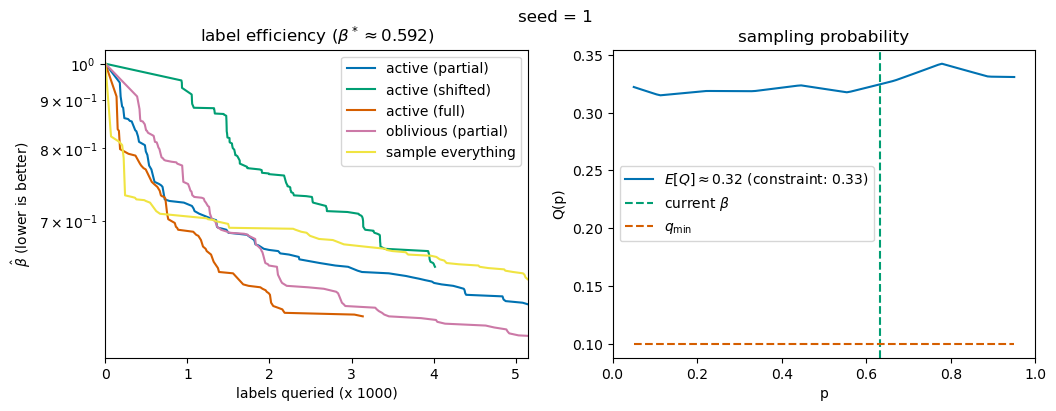

betastar = 0.591751709536137
max bet = 0.5454545454545455
n    	 L    	 bet       	 beta      	 p                                                           	 Q(p)                                                        	 cons      	 dual      	
    0	     4	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40]	 -6.422e-02	 3.069e-01	
  128	    40	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21]	 1.256e-01	 0.000e+00	
  256	    79	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22]	 1.134e-01	 0.000e+00	
  512	   135	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22]	 1.164e-01	 0.000e+00	
 1024	   248	5.042e-02	 6.667e-01	 [0.05 0.14 0.23 0.32 0.41 0.

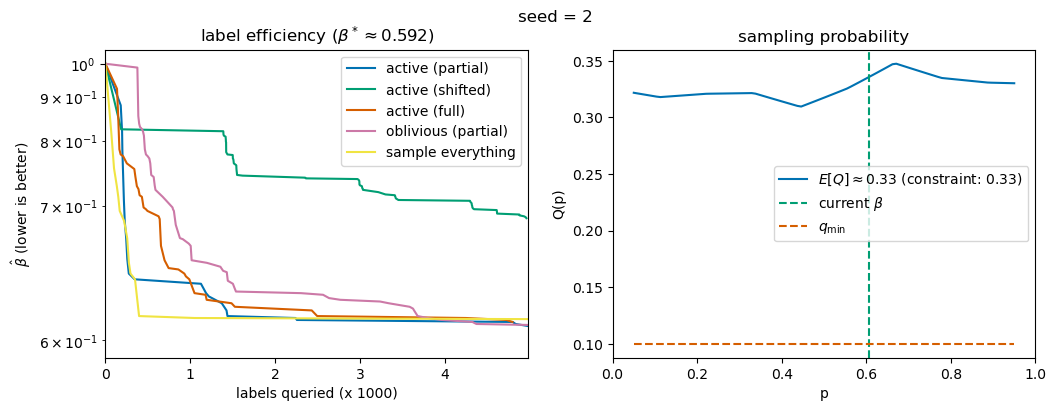

betastar = 0.591751709536137
max bet = 0.5454545454545455
n    	 L    	 bet       	 beta      	 p                                                           	 Q(p)                                                        	 cons      	 dual      	
    0	     5	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40]	 -6.436e-02	 3.069e-01	
  128	    38	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19]	 1.409e-01	 0.000e+00	
  256	    72	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.20 0.19 0.20 0.20 0.20 0.19 0.19 0.20 0.20 0.20 0.20]	 1.376e-01	 0.000e+00	
  512	   125	5.042e-02	 1.000e+00	 [0.05 0.14 0.23 0.32 0.41 0.50 0.59 0.68 0.77 0.86 0.95]	 [0.20 0.20 0.20 0.20 0.20 0.20 0.20 0.20 0.20 0.20 0.20]	 1.367e-01	 0.000e+00	
 1024	   259	5.042e-02	 7.848e-01	 [0.05 0.14 0.23 0.32 0.41 0.

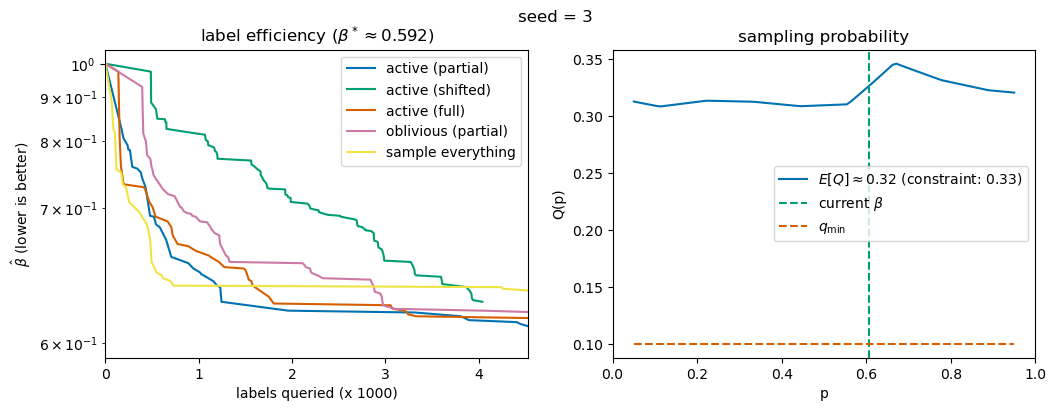

In [3]:
class FalsePositiveRho(object):
    def __init__(self):
        super().__init__()

    def __call__(self, PXY, betas):
        import numpy as np
        (P, _), Y = PXY
        return (1 - Y) * (betas <= np.array(P))

    def sample(self):
        import torch
        
        p = torch.rand(1)
        y = torch.bernoulli(p)
        return p, y
    
%matplotlib inline
def test_once(seed):
    from IwUpperMartingale import FullIwUpperMartingale, PartialIwUpperMartingale, FullyObservedUpperMartingale, ShiftedIwUpperMartingale
    from OnlineMinimax import OnlineMinimax, WindowedBeTheLeader
    from LogisticRegression import MultilabelRegressor
    import numpy as np
    import torch
    
    if True:
        torch.manual_seed(seed)
        np.set_printoptions(2, floatmode='fixed')

        rho = FalsePositiveRho()
        theta = 1/12
        q_min = 1/10
        target_rate = 1/3

        knots = np.linspace(0, 1, 10)
        def featurize(p):
            rv = [0]*len(knots)

            if p >= knots[-1]:
                rv[-1] = 1
            else:
                z = np.digitize(p, knots)
                vlow, vhigh = knots[z-1], knots[z]
                frac = (p - vlow) / (vhigh - vlow)
                rv[z] = frac
                rv[z - 1] = 1 - frac

            return rv

        def makeMinimax(policy, q_min, target_rate, iwmart):
            import cocob

            betastar = 1 - np.sqrt(2 * theta)
            opt = cocob.COCOB(policy.parameters())
            policy.constant_init(target_rate)

            primal_player = LabellingPolicyPrimalPlayer(policy=policy, 
                                                        q_min=q_min,
                                                        target_rate=target_rate,
                                                        theta=theta,
                                                        rho=rho,
                                                        opt=opt,
                                                        sched=None,
                                                        iwmart=iwmart)
            # anything bigger than (1 - Log[2]) should be good enough for max_dual
            dual_player = WindowedBeTheLeader(max_dual=1 - np.log(2), window_size=256)
            return betastar, OnlineMinimax(primal_player=primal_player, dual_player=dual_player)        
        
        betastar, minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=True),
                                                q_min=q_min, 
                                                target_rate=target_rate,
                                                iwmart=PartialIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                               )
        partial_minimax = minimax
        print(f'betastar = {betastar}')
        _, shifted_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=True),
                                         q_min=q_min, 
                                         target_rate=target_rate,
                                         iwmart=ShiftedIwUpperMartingale(rho=rho, theta=theta, n_betas=1000, alpha=0.05),
                                        )
        print(f'max bet = {shifted_minimax._primal_player._iwmart._maxlam}')
        _, full_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=True),
                                      q_min=q_min, 
                                      target_rate=target_rate,
                                      iwmart=FullIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                      )
        _, const_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=False), 
                                       q_min=q_min, 
                                       target_rate=target_rate,
                                       iwmart=PartialIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                      )
        _, fobv_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=False), 
                                      q_min=1, 
                                      target_rate=2,
                                      iwmart=FullyObservedUpperMartingale(rho=rho, theta=theta, n_betas=1000, alpha=0.05))

        suml, sumls, betas = 0, [0], [minimax._primal_player._iwmart.curbeta[0]]
        shiftedsuml, shiftedsumls, shiftedbetas = 0, [0], [shifted_minimax._primal_player._iwmart.curbeta[0]]
        fullsuml, fullsumls, fullbetas = 0, [0], [full_minimax._primal_player._iwmart.curbeta[0]]
        constsuml, constsumls, constbetas = 0, [0], [const_minimax._primal_player._iwmart.curbeta[0]]
        fobvsuml, fobvsumls, fobvbetas = 0, [0], [fobv_minimax._primal_player._iwmart.curbeta[0]]

    monitorthis = partial_minimax
    print(f'{"n":5s}\t', f'{"L":5s}\t', f'{"bet":10s}\t', f'{"beta":10s}\t', f'{"p":60s}\t', f'{"Q(p)":60s}\t', f'{"cons":10s}\t', f'{"dual":10s}\t')
    for n in range(1 + (1 << 14)):
        p, y = rho.sample()
        x = torch.Tensor([featurize(z) for z in p])
        minimax.addobs( ((p, x), y) )
        beta = minimax._primal_player._iwmart.curbeta[0]
        if beta < betas[-1]:
            sumls.append(minimax._primal_player._suml)
            betas.append(beta)
            
        full_minimax.addobs( ((p, x), y) )
        fullbeta = full_minimax._primal_player._iwmart.curbeta[0]
        if fullbeta < fullbetas[-1]:
            fullsumls.append(full_minimax._primal_player._suml)
            fullbetas.append(fullbeta)
            
        shifted_minimax.addobs( ((p, x), y) )
        shiftedbeta = shifted_minimax._primal_player._iwmart.curbeta[0]
        if shiftedbeta < shiftedbetas[-1]:
            shiftedsumls.append(shifted_minimax._primal_player._suml)
            shiftedbetas.append(shiftedbeta)
            
        const_minimax.addobs( ((p, torch.zeros_like(x)), y) )
        constbeta = const_minimax._primal_player._iwmart.curbeta[0]
        if constbeta < constbetas[-1]:
            constsumls.append(const_minimax._primal_player._suml)
            constbetas.append(constbeta)
            
        fobv_minimax.addobs( ((p, torch.zeros_like(x)), y) )
        fobvbeta = fobv_minimax._primal_player._iwmart.curbeta[0]
        if fobvbeta < fobvbetas[-1]:
            fobvsumls.append(fobv_minimax._primal_player._suml)
            fobvbetas.append(fobvbeta)
            
        if n % 128 == 0 and (n//128 & (n//128 - 1)) == 0:
            with torch.no_grad():
                p = np.linspace(0.05, 0.95, 11)
                X = torch.Tensor([ featurize(z) for z in p ])
                (Q, _), cons = monitorthis._primal_player.predict( ((p, X), None) )
                dual = monitorthis._dual_player.predict(peek=-cons)
                lam = monitorthis._primal_player._iwmart.curlam
                beta = monitorthis._primal_player._iwmart.curbeta[0]
                suml = int(monitorthis._primal_player._suml)
                print(f'{n:5d}\t', f'{suml:5d}\t' f'{lam:.03e}\t', f'{beta:.03e}\t', f'{p}\t', f'{Q.numpy()}\t', f'{cons:.3e}\t', f'{dual:.3e}\t')
                
    with torch.no_grad():
        import matplotlib.pyplot as plt 
        with plt.style.context("seaborn-colorblind"):
            fig, ax = plt.subplots(1, 2, figsize=(12, 4))
            fig.suptitle(f'seed = {seed}')
            ax[0].plot(np.array(sumls)/1000, betas, label='active (partial)')
            ax[0].plot(np.array(shiftedsumls)/1000, shiftedbetas, label='active (shifted)')
            ax[0].plot(np.array(fullsumls)/1000, fullbetas, label='active (full)')
            ax[0].plot(np.array(constsumls)/1000, constbetas, label='oblivious (partial)')
            ax[0].plot(np.array(fobvsumls)/1000, fobvbetas, label='sample everything')
            ax[0].set_xlim((sumls[0]/1000, sumls[-1]/1000))
            ax[0].set_xlabel('labels queried (x 1000)')
            ax[0].set_ylabel('$\\hat{\\beta}$ (lower is better)')
            ax[0].set_yscale("functionlog", functions=[lambda x: x - betastar + 5e-2, lambda x: x + betastar - 5e-2])
            ax[0].set_title('label efficiency $(\\beta^* \\approx' + f'{betastar:.3f})$')
            ax[0].legend()
            
            p = np.linspace(0.05, 0.95, 101)
            X = torch.Tensor([ featurize(z) for z in p ])
            (Q, _), cons = monitorthis._primal_player.predict( ((p, X), None) )
            
            ax[1].plot(p, Q.numpy(), label=f'$E[Q] \\approx {torch.mean(Q).item():.2f}$ (constraint: {target_rate:.2f})')
            vline_color = next(plt.gca()._get_lines.prop_cycler)['color']
            ax[1].axvline(x=monitorthis._primal_player._iwmart.curbeta[0], label='current $\\beta$', linestyle='dashed', color=vline_color)
            ax[1].plot(p, [q_min]*len(p), label='$q_\\min$', linestyle='dashed')
            ax[1].set_xlim((0, 1))
            ax[1].set_xlabel('p')
            ax[1].set_ylabel('Q(p)')
            ax[1].set_title('sampling probability')
            ax[1].legend()
            plt.show()
    
def test():
    for seed in range(1, 4):
        test_once(seed=seed)

test()

  0%|          | 0/49 [00:00<?, ?it/s]

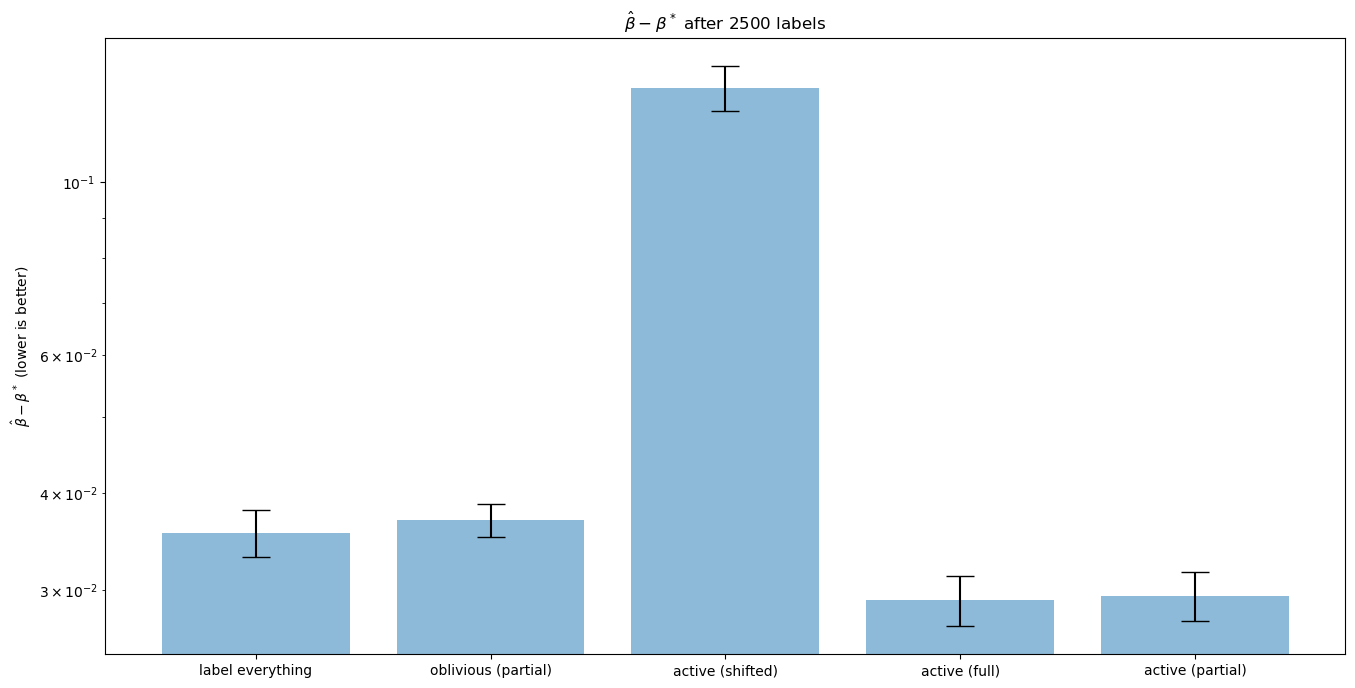

{'label everything': {'average': 0.03554906062177602,
  'stdmean': 0.0024689688411791573},
 'oblivious (partial)': {'average': 0.03687691909249165,
  'stdmean': 0.0018351653434230725},
 'active (shifted)': {'average': 0.132258014473587,
  'stdmean': 0.008626140729304028},
 'active (full)': {'average': 0.02911405418676959,
  'stdmean': 0.002162254384603317},
 'active (partial)': {'average': 0.0295021974320557,
  'stdmean': 0.002094243324545016}}

In [5]:
class FalsePositiveRho(object):
    def __init__(self):
        super().__init__()

    def __call__(self, PXY, betas):
        import numpy as np
        (P, _), Y = PXY
        return (1 - Y) * (betas <= np.array(P))

    def sample(self):
        import torch
        
        p = torch.rand(1)
        y = torch.bernoulli(p)
        return p, y
    
%matplotlib inline
def test_once(*, seed, report_at):
    from IwUpperMartingale import FullIwUpperMartingale, PartialIwUpperMartingale, FullyObservedUpperMartingale, ShiftedIwUpperMartingale
    from OnlineMinimax import OnlineMinimax, WindowedBeTheLeader
    from LogisticRegression import MultilabelRegressor
    import numpy as np
    import torch
    
    if True:
        torch.manual_seed(seed)
        np.set_printoptions(2, floatmode='fixed')

        rho = FalsePositiveRho()
        theta = 1/12
        q_min = 1/10
        target_rate = 1/3

        knots = np.linspace(0, 1, 10)
        def featurize(p):
            rv = [0]*len(knots)

            if p >= knots[-1]:
                rv[-1] = 1
            else:
                z = np.digitize(p, knots)
                vlow, vhigh = knots[z-1], knots[z]
                frac = (p - vlow) / (vhigh - vlow)
                rv[z] = frac
                rv[z - 1] = 1 - frac

            return rv

        def makeMinimax(policy, q_min, target_rate, iwmart):
            import cocob

            betastar = 1 - np.sqrt(2 * theta)
            opt = cocob.COCOB(policy.parameters())
            policy.constant_init(target_rate)

            primal_player = LabellingPolicyPrimalPlayer(policy=policy, 
                                                        q_min=q_min,
                                                        target_rate=target_rate,
                                                        theta=theta,
                                                        rho=rho,
                                                        opt=opt,
                                                        sched=None,
                                                        iwmart=iwmart)
            # anything bigger than (1 - Log[2]) should be good enough for max_dual
            dual_player = WindowedBeTheLeader(max_dual=1 - np.log(2), window_size=256)
            return betastar, OnlineMinimax(primal_player=primal_player, dual_player=dual_player)        
        
        betastar, minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=True),
                                                q_min=q_min, 
                                                target_rate=target_rate,
                                                iwmart=PartialIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                               )
        partial_minimax = minimax
        _, shifted_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=True),
                                         q_min=q_min, 
                                         target_rate=target_rate,
                                         iwmart=ShiftedIwUpperMartingale(rho=rho, theta=theta, n_betas=1000, alpha=0.05),
                                        )
        _, full_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=True),
                                      q_min=q_min, 
                                      target_rate=target_rate,
                                      iwmart=FullIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                      )
        _, const_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=False), 
                                       q_min=q_min, 
                                       target_rate=target_rate,
                                       iwmart=PartialIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=1000, alpha=0.05),
                                      )
        _, fobv_minimax = makeMinimax(policy=MultilabelRegressor(in_features=len(featurize(0.1)), out_classes=1, bias=False), 
                                      q_min=1, 
                                      target_rate=2,
                                      iwmart=FullyObservedUpperMartingale(rho=rho, theta=theta, n_betas=1000, alpha=0.05))

        suml, sumls, betas = 0, [0], [minimax._primal_player._iwmart.curbeta[0]]
        shiftedsuml, shiftedsumls, shiftedbetas = 0, [0], [shifted_minimax._primal_player._iwmart.curbeta[0]]
        fullsuml, fullsumls, fullbetas = 0, [0], [full_minimax._primal_player._iwmart.curbeta[0]]
        constsuml, constsumls, constbetas = 0, [0], [const_minimax._primal_player._iwmart.curbeta[0]]
        fobvsuml, fobvsumls, fobvbetas = 0, [0], [fobv_minimax._primal_player._iwmart.curbeta[0]]

    betas = {}
    while True:
        p, y = rho.sample()
        x = torch.Tensor([featurize(z) for z in p])
        partial_minimax.addobs( ((p, x), y) )
        if partial_minimax._primal_player._suml == report_at:
            betas['active (partial)'] = partial_minimax._primal_player._iwmart.curbeta[0] - betastar
            
        full_minimax.addobs( ((p, x), y) )
        if full_minimax._primal_player._suml == report_at:
            betas['active (full)'] = full_minimax._primal_player._iwmart.curbeta[0] - betastar
            
        shifted_minimax.addobs( ((p, x), y) )
        if shifted_minimax._primal_player._suml == report_at:
            betas['active (shifted)'] = shifted_minimax._primal_player._iwmart.curbeta[0] - betastar
            
        const_minimax.addobs( ((p, torch.zeros_like(x)), y) )
        if const_minimax._primal_player._suml == report_at:
            betas['oblivious (partial)'] = const_minimax._primal_player._iwmart.curbeta[0] - betastar
            
        fobv_minimax.addobs( ((p, torch.zeros_like(x)), y) )
        if fobv_minimax._primal_player._suml == report_at:
            betas['label everything'] = fobv_minimax._primal_player._iwmart.curbeta[0] - betastar
            
        if all(v._primal_player._suml >= report_at for v in (partial_minimax, full_minimax, shifted_minimax, const_minimax, fobv_minimax,)):
            break
            
    return betas

def test():
    from tqdm.auto import trange
    import numpy as np
    
    report_at = 2500
    res = []
    for seed in trange(1, 50, position=0):
        res.append(test_once(seed=seed, report_at=report_at))
    
    rv = {}
    for k in res[0].keys():
        rv[k] = { 'average': np.mean([ v[k] for v in res ]),
                  'stdmean': np.std([ v[k] for v in res ]) / np.sqrt(len(res)),
                }
        
    import matplotlib.pyplot as plt 
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.bar(list(k for k, _ in rv.items()), 
           list(v['average'] for _, v in rv.items()),
           yerr=list(v['stdmean'] for _, v in rv.items()),
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('$\\hat{\\beta} - \\beta^*$ (lower is better)')
    ax.set_yscale('log')
    plt.title('$\\hat{\\beta} - \\beta^*$ ' + f'after {report_at} labels')
    
    plt.show()
           
    return rv

test()

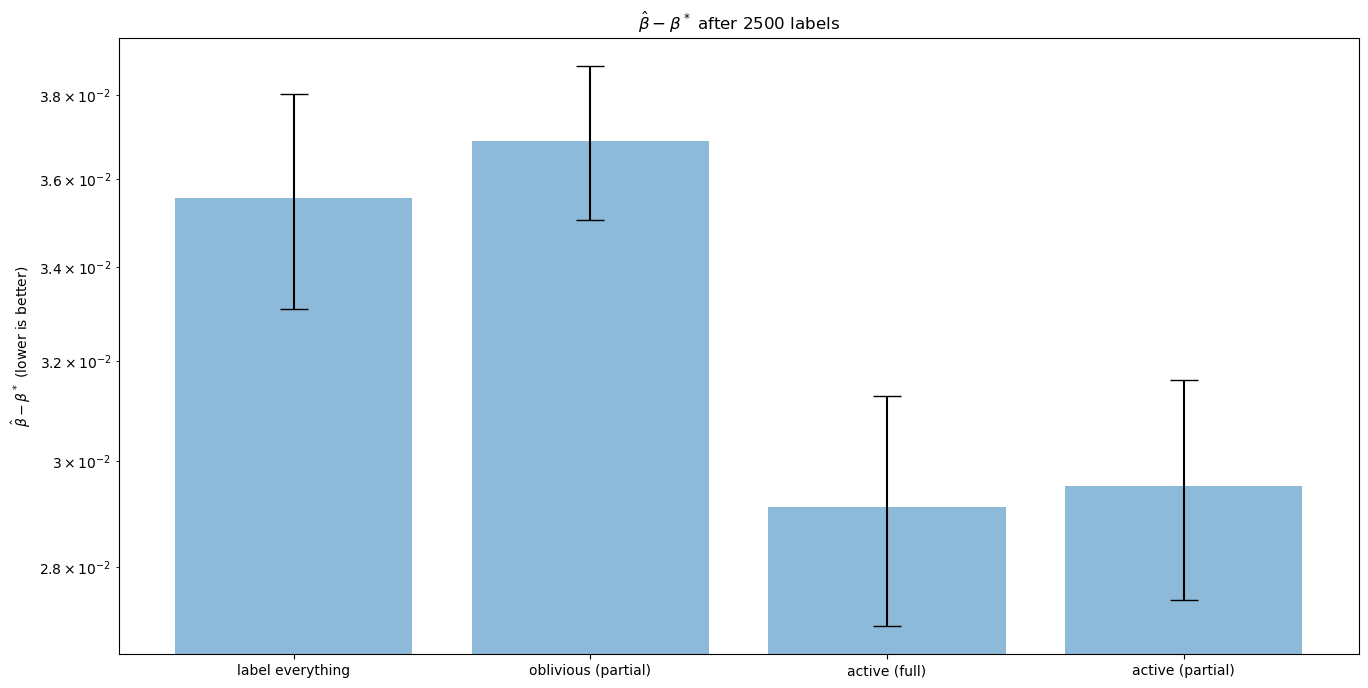

In [6]:
def megaplot(report_at):
    rv = {'label everything': {'average': 0.03554906062177602,
  'stdmean': 0.0024689688411791573},
 'oblivious (partial)': {'average': 0.03687691909249165,
  'stdmean': 0.0018351653434230725},
 'active (shifted)': {'average': 0.132258014473587,
  'stdmean': 0.008626140729304028},
 'active (full)': {'average': 0.02911405418676959,
  'stdmean': 0.002162254384603317},
 'active (partial)': {'average': 0.0295021974320557,
  'stdmean': 0.002094243324545016}}
    
    if True:
        del rv['active (shifted)']

        import matplotlib.pyplot as plt 

        fig, ax = plt.subplots(figsize=(16, 8))
        ax.bar(list(k for k, _ in rv.items()), 
               list(v['average'] for _, v in rv.items()),
               yerr=list(v['stdmean'] for _, v in rv.items()),
               align='center', alpha=0.5, ecolor='black', capsize=10)
        ax.set_ylabel('$\\hat{\\beta} - \\beta^*$ (lower is better)')
        ax.set_yscale('log')
        plt.title('$\\hat{\\beta} - \\beta^*$ ' + f'after {report_at} labels')

        plt.show()
    
megaplot(2500)

# One-D Sim (Analysis for "full" variant of martingale)

\begin{alignat*}{2}
&\! \max_{q \succeq 0} & \qquad & \sum_j p(x_j) q(x_j) \mathbb{E}_y\left[ \log\left(1 + \frac{\lambda}{q(x_j)} \left( \theta - \rho(x_j, y, \beta) \right) \right) \right]  \\
& \text{subject to} & & \sum_j p(x_j) q(x_j) \leq c.
\end{alignat*}
Lower bound objective.
\begin{align}
& q(x_j) \mathbb{E}_y\left[ \log\left(1 + \frac{\lambda}{q(x_j)} \left( \theta - \rho(x_j, y, \beta) \right) \right) \right] \\
&\geq q(x_j) \mathbb{E}_y\left[ \frac{\lambda}{q(x_j)} \left( \theta - \rho(x_j, y, \beta) \right) - \frac{\psi(\lambda)}{q(x_j)^2} \left( \theta - \rho(x_j, y, \beta) \right)^2 \right] & \left( \psi(\lambda) \doteq -\lambda - \log(1 - \lambda) \right) \\
&= \lambda \left( \theta - \mathbb{E}_y\left[\rho(x_j, y, \beta)\right] \right) - \frac{1}{q(x_j)} \psi(\lambda) \mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right] 
\end{align}
Substitute
\begin{alignat*}{2}
&\! \min_{q \succeq 0} & \qquad & \sum_j \frac{p(x_j)}{q(x_j)} \psi(\lambda) \mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right]  \\
& \text{subject to} & & \sum_j p(x_j) q(x_j) \leq c.
\end{alignat*}
Substitute $\phi(x_j) \leftarrow p(x_j) q(x_j)$, 
\begin{alignat*}{2}
&\! \min_{q \succeq 0} & \qquad & \sum_j \frac{p^2(x_j)}{\phi(x_j)} \psi(\lambda) \mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right]  \\
& \text{subject to} & & \sum_j \phi(x_j) \leq c.
\end{alignat*}
This has solution $\phi(x_j) \propto p(x_j) \sqrt{\mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right]}$ which implies $q(x_j) \propto \sqrt{\mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right]}$.

**Simulation**: $y \sim \text{Bournelli}(x_j)$, $\rho$ is false positive rate, and $\beta$ is classifier threshold,  
\begin{align}
\rho(x_j, y, \beta) &= 1_{\beta \leq x_j} (1 - y) \\
\mathbb{E}_y\left[ \rho(x_j, y, \beta) \right] &= 1_{\beta \leq x_j} (1 - x_j) \\
\mathbb{E}_y\left[ \rho(x_j, y, \beta)^2 \right] &= 1_{\beta \leq x_j} (1 - x_j) \\
\mathbb{E}_y\left[\left( \theta - \rho(x_j, y, \beta) \right)^2 \right] &= \theta^2 + \left(1 -  2 \theta\right) 1_{\beta \leq x_j} (1 - x_j)
\end{align}
So we should anticipate
* When $\beta = 1$, sampling should be constant, since $1_{\beta \leq x_j} (1 - x_j)$ is zero everywhere.
* When $\beta < 1$ and $\theta < 1/2$, sampling should be
  * constant for $x_j < \beta$ since $1_{\beta \leq x_j} (1 - x_j)$ is zero in this regime, and
  * jump to a higher sampling rate it $x_j = \beta$ since $1_{\beta \leq x_j} (1 - x_j)$ is maximized at that point, and
  * sample at a decreasing rate as $x_j$ increases above $\beta$ since  $1_{\beta \leq x_j} (1 - x_j)$ is decreasing.
